# Olivia Walters - Linear RM Grid Signal Processing Demo

## Setup

Some functions that were apart of the larger project, copy-pasted locally for easy distribution.

In [1]:
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

In [2]:
def plot_RMs(rms, scale=1):
        rms_pos = np.array(list(filter(lambda val: val[2] > 0, rms.transpose()))).transpose()
        rms_neg = np.array(list(filter(lambda val: val[2] < 0, rms.transpose()))).transpose()

        plt.scatter(rms_pos[0] * scale, rms_pos[1] * scale, s=rms_pos[2], color=(1, 1, 1, 0), edgecolors='red', linewidth=2)
        plt.scatter(rms_neg[0] * scale, rms_neg[1] * scale, s=-1 * rms_neg[2], color=(1, 1, 1, 0), edgecolors='blue', linewidth=2)

To start off with, we'll generate a random grid of points in a square degree field to simulate an RM grid. This grid measurement will then be overlaid with a black and white image of any choice. The default will be a copy of the Planck CMB (because it looks noisy and 'blobby').

Make sure your input image is in same directory and is black and white (in RGB format) and square.

JPEG
(214, 214)
RGB


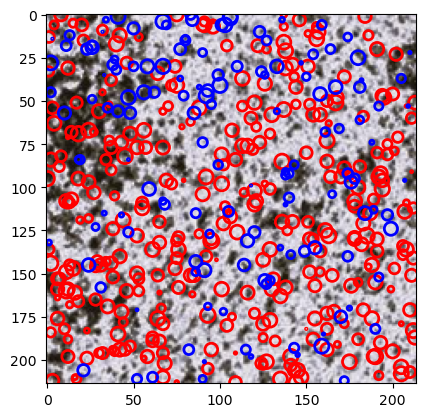

In [187]:
# Create random RM grid

resolution = 30
gridn = 4 # width of field in degrees
points = resolution*gridn**2


image = Image.open('cmb_cropped_BW.jpg')
 
# Summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
#image.show()

# Get the image data as an array
width, height = image.size
image_arr = list(map(lambda px: int((px[0]+px[1]+px[2])/3), list(image.getdata())))
image_arr = [image_arr[i*width:(i+1)*width] for i in range(height)]
#print(image_arr)

# Generate simulated lists
xy = np.array(random.sample([(x,y) for x in range(width) for y in range(height)], points))
x = xy.transpose()[0]
y = xy.transpose()[1]
s = []

# Develop 30 random numbers as POIs
for i in range(points):
    # Set zero point to be 50% of 256, or 128
    s.append(image_arr[x[i]][y[i]]-128)

# Convert to single degree scale
x = gridn * x/(width)
y = gridn * y/(height)

ss = np.array([x, y, s])

plt.imshow(image)
plot_RMs(ss, width/gridn)
plt.show()

RM grid data from POSSUM can also be used as an input method.

Now that we have our RM grid, we can start applying our analysis tools and seeing their effect.

## Convolutional Blurring

### Kernel Creation

Before we can create our blurring algortithim, we first need to design a kernel. The primary issue is that we want our kernel size to be dynamic i.e. the code adapts to square kernels of different sizes. Thus we need to develop a small program to create a kernel for us automatically, and save the results in a .dat file.

In [152]:
"""
    Creates a square kernel for evaluating the convolution. Kernel values must have an integral equal to 1. Kernels must be rotationally symmetric, however, if future eliptical kernels will be used, then it is as an array of rows as to make it easier to save.

    Shape can take on values: "box", "gaussian", "annulus", "sinc", negsinc".

    Size is the amount of pixels the kernel has on it's side.

    Box parameters: None
    Gaussian parameters: (FWHM)
"""
def make_kernel(shape, size, parameters=None, edge_sharpness=0):
    if shape == "box":
        return [[1/size**2]*size for i in range(size)]
    
    if shape == "gaussian":
        space = np.linspace(0, size, size)
        stdev = parameters[0]/(2*np.sqrt(2*np.log(2))) # FWHM = 2 * sqrt(2 * ln2) * std
        xspace = np.array(norm.pdf(space, loc=size/2, scale=stdev))
        kernel = []
        for x in xspace:
            kernel.append(list(xspace*x))
        return kernel

    print("Kernel made.")

"""
    Checks if kernel values when convolved with flat image is 1 (i.e. proper weighted mean)
"""
def check_normal(kernel):
    total = 0
    for y in range(len(kernel)):
        for x in range(len(kernel[y])):
            total += kernel[y][x]
    print("Kernel sum: "+str(total))
    return math.isclose(total, round(total))

"""
    Saves a created kernel to a .dat file in the directory.
"""
def save_kernel(kernel, filename='./output_kernel'):

    with open(filename+".dat", "w") as file:
        
        for y in range(len(kernel)):
            file.write(" ".join(list(map(str, kernel[y])))+"\n")
    
    print("Kernel saved.")

"""
    Loads a kernel from a given .dat file.
"""
def load_kernel(filename='./output_kernel'):
    kernel = []
    with open(filename+".dat", "r") as file:
        for row in file:
            kernel.append(list(map(float, row[:-1:1].split(" "))))

    print("Kernel loaded.")
    return kernel

[[2.3100291430674373e-26, 4.5651491894095873e-23, 2.80698805997392e-20, 5.369999313397266e-18, 3.196362078128264e-16, 5.9195103378050385e-15, 3.410858253664105e-14, 6.114903874966004e-14, 3.410858253664105e-14, 5.919510337805049e-15, 3.196362078128272e-16, 5.369999313397284e-18, 2.80698805997392e-20, 4.5651491894095873e-23, 2.3100291430674373e-26], [4.5651491894095873e-23, 9.021785367561749e-20, 5.547254373447634e-17, 1.0612354431222819e-14, 6.316747039238891e-13, 1.1698314673402126e-11, 6.740640843703467e-11, 1.2084457268383323e-10, 6.740640843703467e-11, 1.1698314673402147e-11, 6.316747039238907e-13, 1.0612354431222855e-14, 5.547254373447634e-17, 9.021785367561749e-20, 4.5651491894095873e-23], [2.80698805997392e-20, 5.547254373447634e-17, 3.4108582536640897e-14, 6.5252527224649946e-12, 3.88399870001014e-10, 7.192980611944537e-09, 4.1446396557513625e-08, 7.430409359305967e-08, 4.1446396557513625e-08, 7.192980611944549e-09, 3.883998700010149e-10, 6.525252722465017e-12, 3.41085825366408

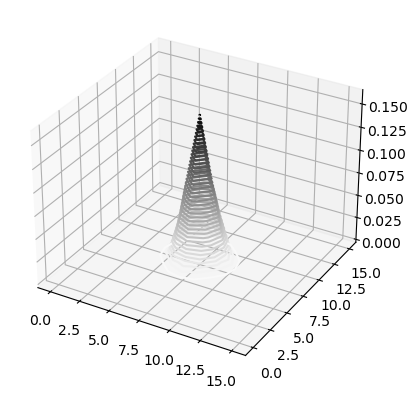

In [166]:
box = make_kernel("gaussian", 15, [2.335])
print(box)
print(check_normal(box))
save_kernel(box, "output_kernel")
#print(load_kernel("output_kernel"))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(np.linspace(0, 15, 15), np.linspace(0, 15, 15), box, 50, cmap='binary')
plt.show()

### Performing the convolution

We can pull our kernel from a seperate .dat file. This will act as the kernel used for the analysis of the RM grid.

## Non-Uniform Fast Fourier Transforms

We can use the pyNUFFT module to make things easier.

### Preparing the grid/transform object

In [188]:
from pynufft import NUFFT
import scipy.datasets

In [189]:
NufftObj = NUFFT()

image_resolution = 256

sample_points = np.array(list(map(lambda x, y: (x, y), ss[0], ss[1])))

Nd = (image_resolution, image_resolution)  # image size
print('setting image dimension Nd...', Nd)
Kd = (image_resolution, image_resolution)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

NufftObj.plan(sample_points, Nd, Kd, Jd)

setting image dimension Nd... (256, 256)
setting spectrum dimension Kd... (256, 256)
setting interpolation size Jd... (6, 6)


0

In [190]:
def placeRMs(imgres, sample_points, gridn):
    img = np.zeros((imgres, imgres))
    locs = (sample_points * imgres/gridn).astype('i')
    
    for i in range(len(locs)):
        img[*locs[i]] = ss[2][i]
    
    #img = img/max(img.max(), img.min(), key=abs)
    
    #plt.imshow(img.real)
    #plt.show()
    #plt.scatter(*locs.transpose())
    #plt.show()

    return img
    

#image = scipy.datasets.ascent()
#print(image.dtype)
#plt.imshow(image.real)
#plt.show()
img = placeRMs(image_resolution, sample_points, gridn)

### Transforming time

The process is:
Forward transform -> Bandpass -> Adjoint transform
OR
Adjoint transform -> Bandpass -> Forward transform

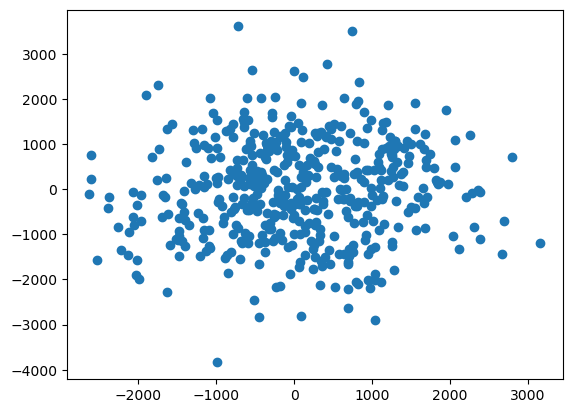

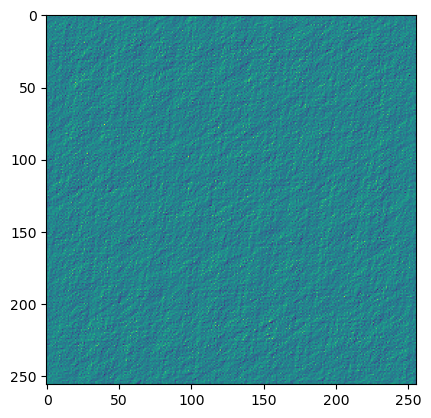

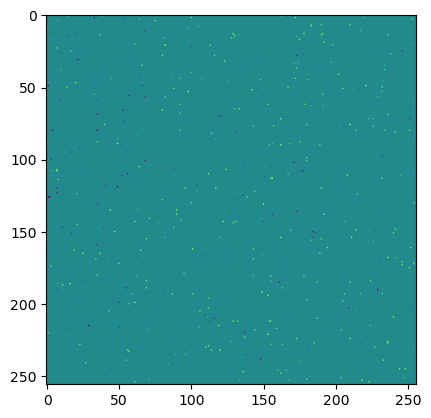

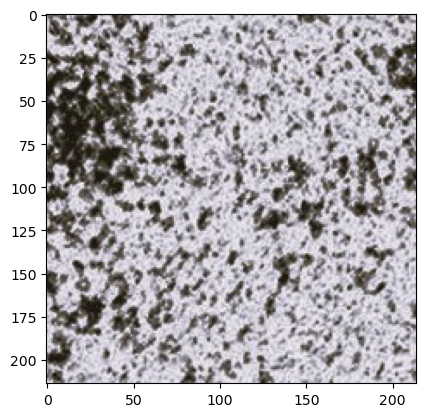

In [191]:
# Forward First

kspace = NufftObj.forward(img)

new_img = NufftObj.adjoint(kspace)

plt.scatter(kspace.real, kspace.imag)
plt.show()

plt.imshow(new_img.real)
plt.show()
plt.imshow(img)
plt.show()
plt.imshow(image)
plt.show()

### What the output looks like

Also we can test if the sky looks similar to what we measured.

480
256
61.16768588801507 61.16866416648596


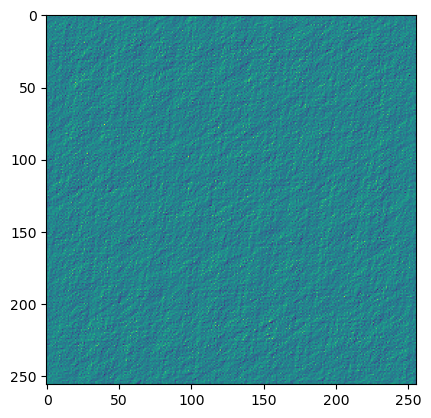

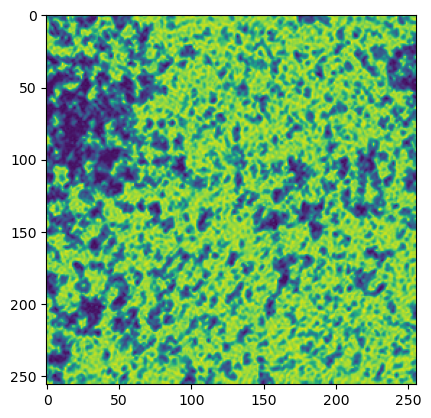

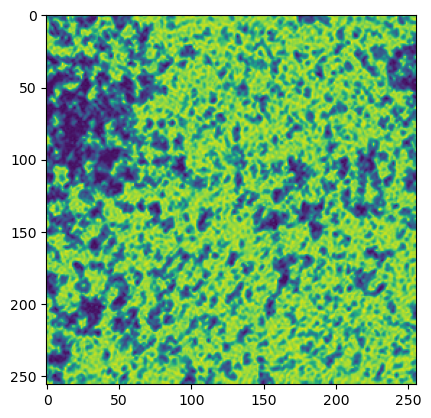

In [192]:
print(len(kspace))
print(len(img))

#from skimage.transform import resize
image_resized = image.resize((256, 256), Image.Resampling.LANCZOS)

width_res, height_res = image_resized.size
image_resized_arr = list(map(lambda px: int((px[0]+px[1]+px[2])/3), list(image_resized.getdata())))
image_resized_arr = np.array([np.array(image_resized_arr[i*width_res:(i+1)*width_res]) for i in range(height_res)]) - 128
#image_resized_arr = image_resized_arr/max(image_resized_arr.max(), image_resized_arr.min(), key=abs)

#new_img_scaled = new_img.real/max(new_img.real.max(), new_img.real.min(), key=abs)

#image_resized = resize(image, (256, 256))
subtraction = image_resized_arr - new_img.real
print(np.std(image_resized_arr), np.std(subtraction))
plt.imshow(new_img.real)
plt.show()
plt.imshow(image_resized_arr)
plt.show()
plt.imshow(subtraction)
plt.show()

### Reviewing the RM strength distributions of each spectra

I.e. seeing what the stdev, skew, etc. is to compare with eachother.

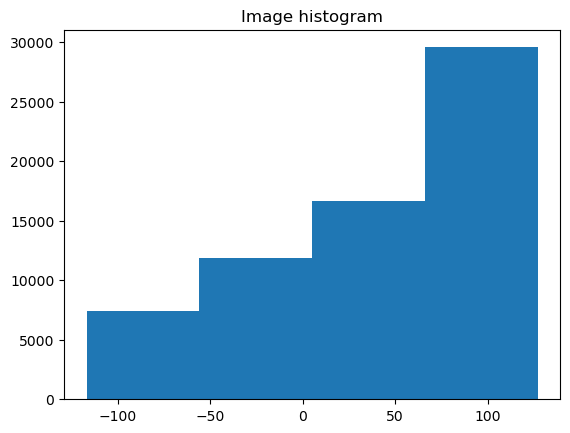

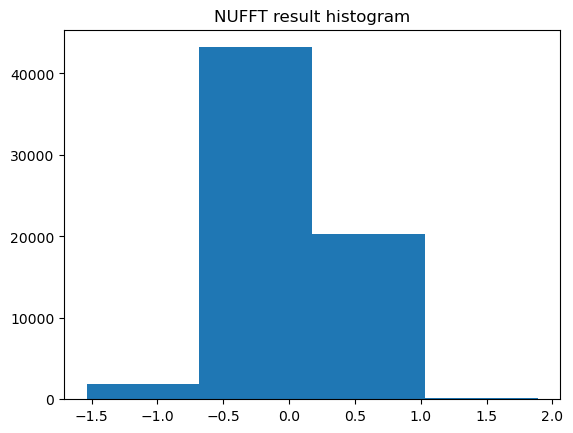

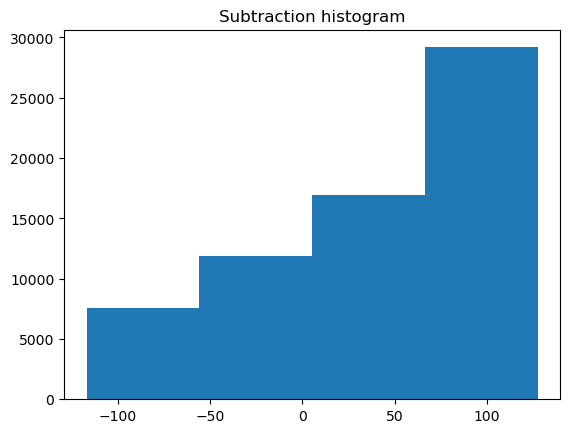

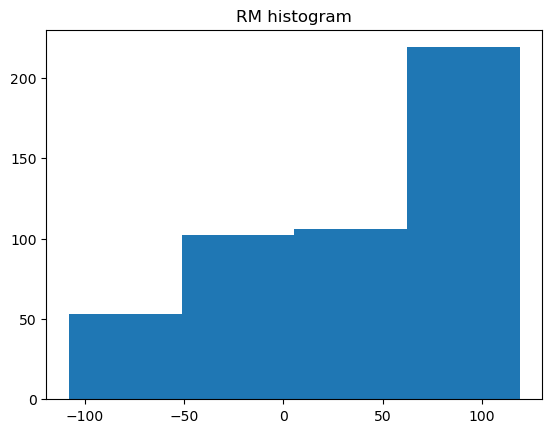

In [193]:
def RM_arr_to_strengths(array):
    return array.flatten()

def get_histogram(array, bins, needtoflatten=False):
    arr = array
    if needtoflatten:
        arr = RM_arr_to_strengths(array)
    
    print(array)

    return np.histogram(array, bins=bins)


# img_resized_arr, new_img_scaled, subtraction, ss (ss[2] is already flattened)
plt.hist(image_resized_arr.flatten(), gridn)
plt.title("Image histogram")
plt.show()
plt.hist(new_img.real.flatten(), gridn)
plt.title("NUFFT result histogram")
plt.show()
plt.hist(subtraction.flatten(), gridn)
plt.title("Subtraction histogram")
plt.show()
plt.title("RM histogram")
plt.hist(ss[2], gridn)
plt.show()